In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

In [41]:
data = pd.read_csv('temperature-1.csv')

In [42]:
data.head()

,Unnamed: 0,Datetime,Hourly_Temp
0,0,04-01-2022 00:00,20.867
1,1,04-01-2022 01:00,21.000
2,2,04-01-2022 02:00,20.867
3,3,04-01-2022 03:00,20.650
4,4,04-01-2022 04:00,20.400


In [43]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d-%m-%Y %H:%M')
data.set_index('Datetime', inplace=True)

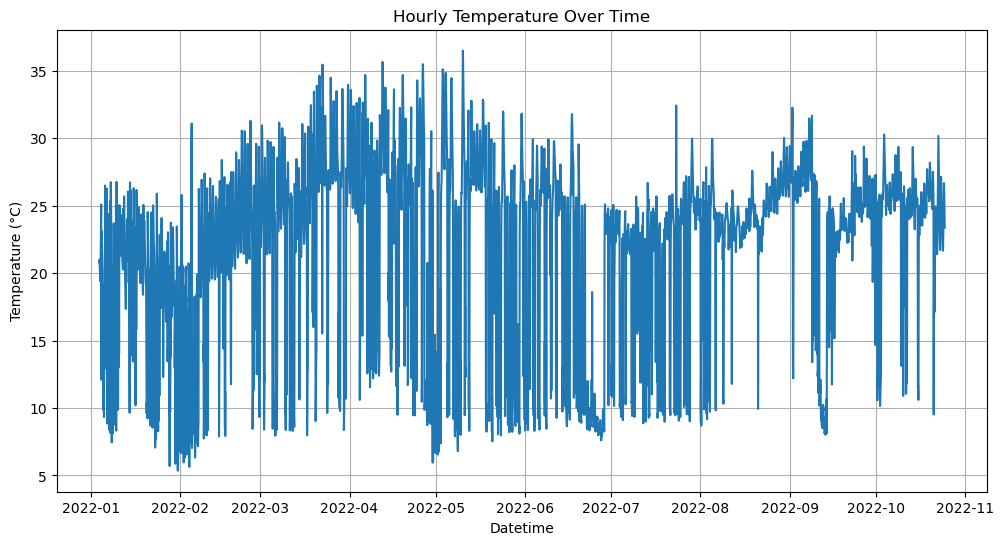

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'])
plt.title('Hourly Temperature Over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()



In [45]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    if dfoutput['p-value'] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

In [46]:
results = test_stationarity(data['Hourly_Temp'])
print(results)

Test Statistic                -9.396891e+00
p-value                        6.338903e-16
#Lags Used                     2.500000e+01
Number of Observations Used    7.030000e+03
Critical Value (1%)           -3.431281e+00
Critical Value (5%)           -2.861951e+00
Critical Value (10%)          -2.566989e+00
dtype: float64
The time series is stationary.
None


In [47]:
data['Temp_Diff'] = data['Hourly_Temp'] - data['Hourly_Temp'].shift(1)
data['Temp_Diff'].dropna(inplace=True)

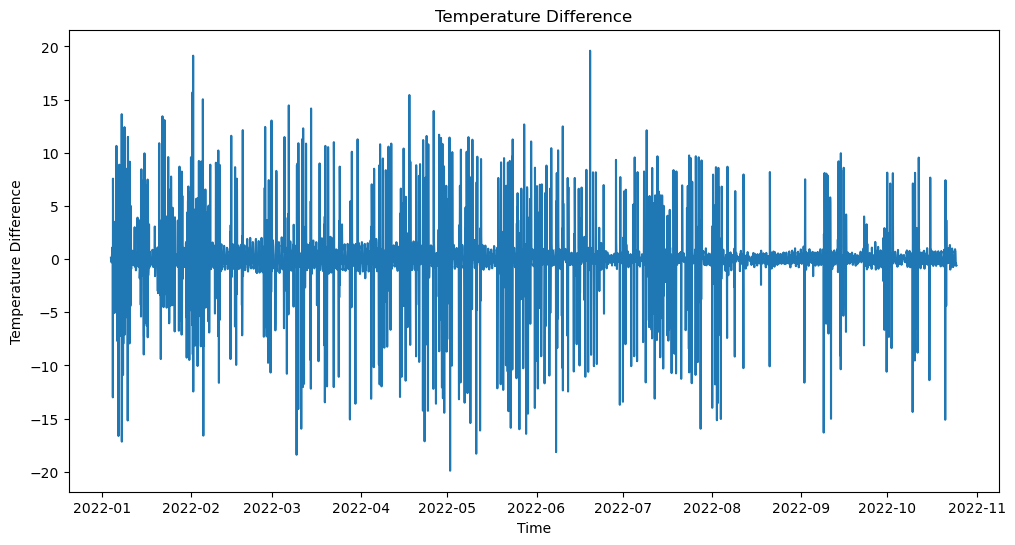

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(data['Temp_Diff'])
plt.title('Temperature Difference')
plt.xlabel('Time')
plt.ylabel('Temperature Difference')
plt.show()


In [50]:
result1 = test_stationarity(data['Temp_Diff'].dropna())
print(result1)

Test Statistic                  -20.546080
p-value                           0.000000
#Lags Used                       35.000000
Number of Observations Used    7019.000000
Critical Value (1%)              -3.431282
Critical Value (5%)              -2.861952
Critical Value (10%)             -2.566989
dtype: float64
The time series is stationary.
None


In [51]:
model = SARIMAX(data['Hourly_Temp'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

In [52]:
forecast_steps = 24  # Forecast for the next 24 hours
forecast = results.get_forecast(steps=forecast_steps)

In [53]:
data_range = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1), periods=forecast_steps, freq='H')

In [54]:
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [56]:
forecast_df = pd.DataFrame({'Datetime': data_range, 'temp': forecast_mean})
forecast_df.set_index('Datetime', inplace=True)

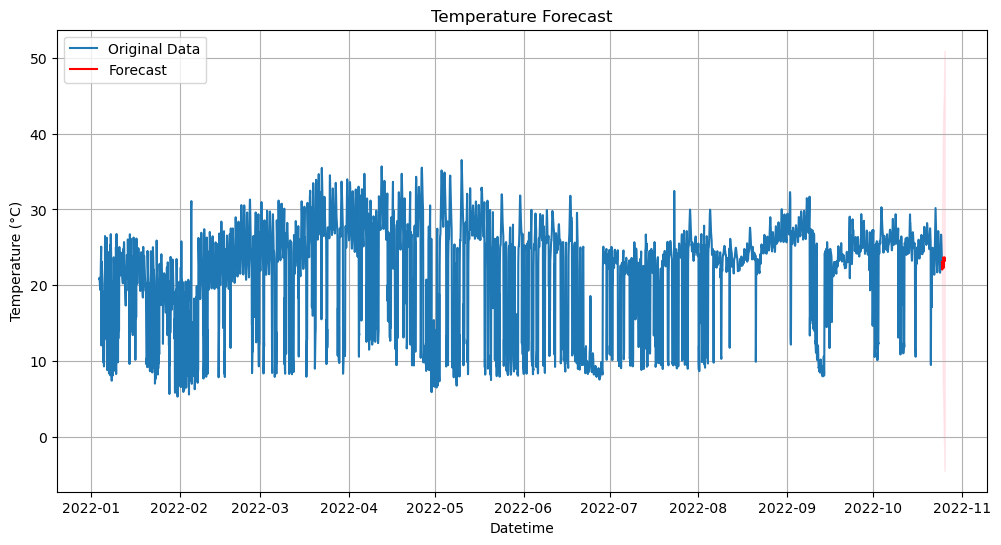

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(data['Hourly_Temp'], label='Original Data')
plt.plot(forecast_df['temp'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Temperature Forecast')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()